<a href="https://colab.research.google.com/github/bopeng-sue/Optimal-Biofluid-Matrices-for-Human-Exposome-Biomonitoring/blob/main/hyperparameter_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import package and file

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # find automatically the path of the folder containing "file_name" :
    file_name = 'hyperparameter_trees.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/CoLab Notebooks/biomarker


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 61.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, roc_auc_score,
    classification_report, roc_curve, precision_recall_curve, auc
)
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import warnings
import sys

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

In [ ]:
df = pd.read_excel('dataset_1211.xlsx')
df.head(2)

,Unnamed: 0,Biomonitor Compound PubChem CID,Blood study numbers,Urine study numbers,Tendency for the selection of blood samples,Biospecimen,CAS Number,Name,SMILES,hhlb(hours),...,JGI10,JGT,VE1_D,VE3_D,VR1_D,VR2_D,SRW5,AMW,WTPT-3,XLogP
0,0,70,0,2,0.0,Urine,816-66-0,4-Methyl-2-oxovaleric acid,CC(C)CC(=O)C(=O)O,0.61,...,0.0,0.601944,0.046505,-2.761367,35.180772,3.908975,0.0,6.845421,7.158910,0.904
1,1,89,0,1,0.0,Urine,484-78-6,Hydroxykynurenine,C1=CC(=C(C(=C1)O)N)C(=O)CC(C(=O)O)N,0.43,...,0.0,0.556317,0.130944,-3.252780,192.246721,12.015420,0.0,8.002847,14.772289,-2.464


# feature function

In [ ]:
def padel_descriptor(df: pd.DataFrame) -> np.ndarray:
    """
    Extracts Padel descriptors from a given DataFrame starting from column index 16
    to the end. It replaces NaN values with 0 and infinite values with 1e10.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing feature columns.

    Returns
    -------
    np.ndarray
        A NumPy array of transformed feature values.
    """
    # Slice columns from index 16 to the end
    X = df.iloc[:, 16:].values

    # Replace NaNs with 0
    X = np.nan_to_num(X, nan=0.0)

    # Replace infinities with a large finite value
    X[np.isinf(X)] = 1e10

    return X

In [ ]:
def maccs_descriptor(smiles_list):
    """
    Generates MACCS fingerprints for a list of SMILES strings and returns them as a DataFrame.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES strings for which MACCS keys will be generated.

    Returns
    -------
    pd.DataFrame
        A DataFrame of MACCS bit values (0 or 1) with column names 'MACCS_1' through 'MACCS_167'.
    """
    # Generate MACCS fingerprints and convert them to a list of bits
    maccs_fingerprints = [
        list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles)).ToBitString())
        for smiles in smiles_list
    ]

    # Convert the list of bits to a DataFrame
    # MACCSkeys are 167 bits long, hence 167 columns
    X = pd.DataFrame(maccs_fingerprints, columns=[f'MACCS_{i}' for i in range(1, 168)])

    # Convert strings to integers (0 and 1)
    X = X.astype(int)

    return X

In [ ]:
def ecfp_descriptor(smiles_list, radius=2, n_bits=1024):
    """
    Generates ECFP (Extended-Connectivity Fingerprints) for a list of SMILES strings
    and returns them as a NumPy array.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES strings for which ECFP fingerprints will be generated.
    radius : int, optional (default=2)
        The fingerprint radius to use. For ECFP4, radius=2 is standard.
    n_bits : int, optional (default=1024)
        Length of the bit vector.

    Returns
    -------
    np.ndarray
        A 2D NumPy array where each row corresponds to the ECFP bit vector of the input SMILES.
    """
    def calculate_ecfp(smiles, radius=radius, n_bits=n_bits):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits, useFeatures=False)
            return np.array(fp)
        else:
            return np.zeros(n_bits, dtype=int)

    # Apply ECFP calculation to the input list of SMILES
    ecfp_fingerprints = np.array([calculate_ecfp(s) for s in smiles_list])
    return ecfp_fingerprints

In [ ]:
def fcfp_descriptor(smiles_list, radius=2, n_bits=1024):
    """
    Generates FCFP (Feature-based Circular Fingerprints) for a list of SMILES strings
    and returns them as a NumPy array.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES strings for which FCFP fingerprints will be generated.
    radius : int, optional (default=2)
        The fingerprint radius to use.
    n_bits : int, optional (default=1024)
        Length of the bit vector.

    Returns
    -------
    np.ndarray
        A 2D NumPy array where each row corresponds to the FCFP bit vector of the input SMILES.
    """
    def calculate_fcfp(smiles, radius=radius, n_bits=n_bits):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits, useFeatures=True)
            return np.array(fp)
        else:
            return np.zeros(n_bits, dtype=int)

    # Apply FCFP calculation to the input list of SMILES
    fcfp_fingerprints = np.array([calculate_fcfp(s) for s in smiles_list])
    return fcfp_fingerprints

In [ ]:
def rdkit_descriptors_to_X(df: pd.DataFrame, smiles_col='SMILES', correlation_threshold=0.95) -> np.ndarray:
    """
    Compute RDKit molecular descriptors for each SMILES in the given DataFrame,
    remove descriptors with zero variance and highly correlated descriptors,
    and return the final feature matrix X.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing at least a 'SMILES' column.
    smiles_col : str, optional
        The name of the column containing SMILES strings.
    correlation_threshold : float, optional
        Threshold above which descriptors are considered highly correlated and removed.

    Returns
    -------
    np.ndarray
        A 2D NumPy array containing the filtered RDKit descriptors.
    """
    # Convert SMILES to RDKit Mol objects
    mol_list = [Chem.MolFromSmiles(s) for s in df[smiles_col]]

    # Define the descriptor names
    descriptor_names = [desc_name[0] for desc_name in Descriptors._descList]

    # Create a descriptor calculator
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

    # Calculate descriptors for each molecule, if mol is None use NaNs
    descriptors_list = [
        calculator.CalcDescriptors(mol) if mol is not None else [np.nan]*len(descriptor_names)
        for mol in mol_list
    ]

    # Convert the list of descriptors to a DataFrame
    descriptors_df = pd.DataFrame(descriptors_list, columns=descriptor_names)

    # Replace NaNs with 0
    descriptors_df = descriptors_df.fillna(0)

    # Step 1: Remove descriptors with zero variance
    variance = descriptors_df.var()
    zero_variance_columns = variance[variance == 0].index
    descriptors_df = descriptors_df.drop(columns=zero_variance_columns)

    # Step 2: Remove descriptors with correlation exceeding the threshold
    corr = descriptors_df.corr().abs()
    to_drop = []

    for i, col1 in enumerate(corr.columns):
        for col2 in corr.columns[i+1:]:
            if corr.loc[col1, col2] > correlation_threshold:
                to_drop.append(col2)

    # Remove duplicates if any
    to_drop = list(set(to_drop))

    # Drop the highly correlated descriptors
    descriptors_df = descriptors_df.drop(columns=to_drop, errors='ignore')

    # Convert the final descriptors DataFrame to a NumPy array
    X = descriptors_df.values

    return X

# Hyperparameter_trees

Descriptor Processor

In [ ]:
def compute_descriptors(df: pd.DataFrame, descriptor_type: str, smiles_col: str='SMILES') -> np.ndarray:
    """
    Computes the specified molecular descriptor for the given DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least the 'SMILES' column.
    descriptor_type : str
        Type of descriptor to compute. One of ['padel', 'maccs', 'ecfp', 'fcfp', 'rdkit'].
    smiles_col : str, optional
        Name of the column containing SMILES strings.

    Returns
    -------
    np.ndarray
        Feature matrix as a NumPy array.
    """
    if descriptor_type.lower() == 'padel':
        X = padel_descriptor(df)
    elif descriptor_type.lower() == 'maccs':
        X = maccs_descriptor(df[smiles_col].tolist()).values
    elif descriptor_type.lower() == 'ecfp':
        X = ecfp_descriptor(df[smiles_col].tolist())
    elif descriptor_type.lower() == 'fcfp':
        X = fcfp_descriptor(df[smiles_col].tolist())
    elif descriptor_type.lower() == 'rdkit':
        X = rdkit_descriptors_to_X(df, smiles_col=smiles_col, correlation_threshold=0.95)
    else:
        raise ValueError("Invalid descriptor_method. Choose from 'padel', 'maccs', 'fcfp', 'ecfp', 'rdkit'.")
    return X

Machine Learning Pipeline

In [ ]:
def run_ml_pipeline(
    X: np.ndarray,
    y: np.ndarray,
    descriptor_type: str,
    model_type: str,
    model_output_path: str='models/',
    max_evals: int=10000,
    random_state: int=42
) -> Dict:
    """
    Runs the machine learning pipeline for a given descriptor type and model type,
    trains the best model, evaluates it, plots ROC and PRC curves, saves the model,
    and returns performance metrics.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Target vector.
    descriptor_type : str
        Descriptor type being processed.
    model_type : str
        Type of model to use. One of ['random_forest', 'extra_trees'].
    model_output_path : str, optional
        Directory path to save the models and plots. Defaults to 'models/'.
    max_evals : int, optional
        Number of evaluations for hyperparameter optimization. Defaults to 10000.
    random_state : int, optional
        Random state for reproducibility. Defaults to 42.

    Returns
    -------
    dict
        A dictionary containing performance metrics.
    """
    # Validate model_type
    if model_type not in ['random_forest', 'extra_trees']:
        raise ValueError("Invalid model_type. Choose from 'random_forest', 'extra_trees'.")

    # Create output directory if it doesn't exist
    Path(model_output_path).mkdir(parents=True, exist_ok=True)

    # ---------------------------
    # 1. Data Splitting
    # ---------------------------

    # Initialize the first split: train + temp (validation + test)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=random_state)
    for train_index, temp_index in sss1.split(X, y):
        X_train, X_temp = X[train_index], X[temp_index]
        y_train, y_temp = y[train_index], y[temp_index]

    # Initialize the second split: validation + test from temp
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=random_state)  # 1/3 validation, 2/3 test
    for val_index, test_index in sss2.split(X_temp, y_temp):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        y_val, y_test = y_temp[val_index], y_temp[test_index]

    print(f"Dataset sizes for {descriptor_type} with {model_type}:")
    print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # ---------------------------
    # 2. Apply SMOTE
    # ---------------------------

    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    print(f"After SMOTE, training set sizes for {descriptor_type} with {model_type}:")
    print(f"X_train_res: {X_train_res.shape}, y_train_res: {y_train_res.shape}")

    # ---------------------------
    # 3. Hyperparameter Optimization with Hyperopt
    # ---------------------------

    if model_type == 'random_forest':
        def objective_rf(space):
            model = RandomForestClassifier(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                max_features=space['max_features'],
                bootstrap=space['bootstrap'],
                random_state=random_state,
                n_jobs=-1
            )

            model.fit(X_train_res, y_train_res)
            preds = model.predict(X_val)

            # Calculate metrics
            balanced_acc = balanced_accuracy_score(y_val, preds)

            # Hyperopt minimizes the loss
            loss = -balanced_acc

            return {'loss': loss, 'status': STATUS_OK}

        # Define the search space for Random Forest
        space_rf = {
                    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
                    'max_depth': hp.quniform('max_depth', 5, 50, 1),
                    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
                    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
                    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
                    'bootstrap': hp.choice('bootstrap', [True, False])
                }

        trials_rf = Trials()
        best_rf = fmin(
            fn=objective_rf,
            space=space_rf,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials_rf,
            rstate=np.random.default_rng(random_state)
        )

        print(f"Best hyperparameters found for Random Forest ({descriptor_type}): ", best_rf)

        # Convert hyperparameters to appropriate types
        best_params_rf = {
            'n_estimators': int(best_rf['n_estimators']),
            'max_depth': int(best_rf['max_depth']),
            'min_samples_split': int(best_rf['min_samples_split']),
            'min_samples_leaf': int(best_rf['min_samples_leaf']),
            'max_features': ['sqrt', 'log2', None][best_rf['max_features']],
            'bootstrap': [True, False][best_rf['bootstrap']],
            'random_state': random_state,
            'n_jobs': -1
        }

        # ---------------------------
        # 4. Train the Best Random Forest Model
        # ---------------------------

        best_model_rf = RandomForestClassifier(**best_params_rf)
        best_model_rf.fit(X_train_res, y_train_res)

        # ---------------------------
        # 5. Evaluation on Test Set
        # ---------------------------

        y_pred_rf = best_model_rf.predict(X_test)
        y_proba_rf = best_model_rf.predict_proba(X_test)[:,1]

        # Calculate metrics
        precision = precision_score(y_test, y_pred_rf, average='binary')
        recall = recall_score(y_test, y_pred_rf, average='binary')
        f1 = f1_score(y_test, y_pred_rf, average='binary')
        balanced_acc = balanced_accuracy_score(y_test, y_pred_rf)
        auc_score = roc_auc_score(y_test, y_proba_rf)

        print(f"\nRandom Forest Model Performance on Test Set ({descriptor_type}):")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print(f"AUC-ROC:   {auc_score:.4f}")

        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_rf))

        # Per-class metrics
        precision_per_class = precision_score(y_test, y_pred_rf, average=None)
        recall_per_class = recall_score(y_test, y_pred_rf, average=None)
        f1_per_class = f1_score(y_test, y_pred_rf, average=None)

        print("Precision per class:", precision_per_class)
        print("Recall per class:", recall_per_class)
        print("F1-Score per class:", f1_per_class)

        # ---------------------------
        # 6. Plotting ROC and Precision-Recall Curves (Random Forest)
        # ---------------------------

        # Set seaborn style for a clean, academic look
        sns.set_style("white")

        # Choose a color palette that's colorblind-friendly and suitable for publications
        palette = sns.color_palette("colorblind")

        # Calculate ROC curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_rf)
        roc_auc = auc(fpr, tpr)

        # Calculate Precision-Recall curve
        precision_vals, recall_vals, thresholds_prc = precision_recall_curve(y_test, y_proba_rf)
        prc_auc = auc(recall_vals, precision_vals)

        # Set up the matplotlib figure with a larger size for better readability
        plt.figure(figsize=(14, 6))

        # ---------------------------
        # Plot ROC Curve
        # ---------------------------
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color=palette[0], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random Guess')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12, labelpad=10)
        plt.ylabel('True Positive Rate', fontsize=12, labelpad=10)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(False)

        # ---------------------------
        # Plot Precision-Recall Curve
        # ---------------------------
        plt.subplot(1, 2, 2)
        plt.plot(recall_vals, precision_vals, color=palette[1], lw=2, label=f'PRC curve (AUC = {prc_auc:.2f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12, labelpad=10)
        plt.ylabel('Precision', fontsize=12, labelpad=10)
        plt.title('Precision-Recall (PRC) Curve', fontsize=14, pad=15)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(False)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the figure with high resolution
        plot_filename_rf = f'{model_output_path}/ROC_PRC_{descriptor_type}_RandomForest.png'
        plt.savefig(plot_filename_rf, dpi=300, bbox_inches='tight')

        # Display the plot
        plt.show()
        print(f"ROC and PRC curves saved to {plot_filename_rf}")

        # ---------------------------
        # 7. Save the Best Random Forest Model
        # ---------------------------

        model_filename_rf = f'{model_output_path}/best_rf_model_{descriptor_type}.joblib'
        joblib.dump(best_model_rf, model_filename_rf)
        print(f"Best Random Forest model saved to {model_filename_rf}\n")

        # ---------------------------
        # 8. Compile Performance Metrics
        # ---------------------------

        results_rf = {
            'Model Type': 'Random Forest',
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Balanced Accuracy': balanced_acc,
            'AUC-ROC': auc_score,
            'AUC-PRC': prc_auc,
            'Model Path': model_filename_rf,
            'Plot Path': plot_filename_rf
        }

    elif model_type == 'extra_trees':
        def objective_et(space):
            model = ExtraTreesClassifier(
                n_estimators=int(space['n_estimators']),
                max_depth=int(space['max_depth']),
                min_samples_split=int(space['min_samples_split']),
                min_samples_leaf=int(space['min_samples_leaf']),
                max_features=space['max_features'],
                bootstrap=space['bootstrap'],
                random_state=random_state,
                n_jobs=-1
            )

            model.fit(X_train_res, y_train_res)
            preds = model.predict(X_val)

            # Calculate metrics
            balanced_acc = balanced_accuracy_score(y_val, preds)

            # Hyperopt minimizes the loss
            loss = -balanced_acc

            return {'loss': loss, 'status': STATUS_OK}

        # Define the search space for Extra Trees
        space_et = {
            'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
            'max_depth': hp.quniform('max_depth', 5, 50, 1),
            'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
            'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
            'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
            'bootstrap': hp.choice('bootstrap', [True, False])
        }

        trials_et = Trials()
        best_et = fmin(
            fn=objective_et,
            space=space_et,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials_et,
            rstate=np.random.default_rng(random_state)
        )

        print(f"Best hyperparameters found for Extra Trees ({descriptor_type}): ", best_et)

        # Convert hyperparameters to appropriate types
        best_params_et = {
            'n_estimators': int(best_et['n_estimators']),
            'max_depth': int(best_et['max_depth']),
            'min_samples_split': int(best_et['min_samples_split']),
            'min_samples_leaf': int(best_et['min_samples_leaf']),
            'max_features': ['sqrt', 'log2', None][best_et['max_features']],
            'bootstrap': [True, False][best_et['bootstrap']],
            'random_state': random_state,
            'n_jobs': -1
        }

        # ---------------------------
        # 4. Train the Best Extra Trees Model
        # ---------------------------

        best_model_et = ExtraTreesClassifier(**best_params_et)
        best_model_et.fit(X_train_res, y_train_res)

        # ---------------------------
        # 5. Evaluation on Test Set
        # ---------------------------

        y_pred_et = best_model_et.predict(X_test)
        y_proba_et = best_model_et.predict_proba(X_test)[:,1]

        # Calculate metrics
        precision = precision_score(y_test, y_pred_et, average='binary')
        recall = recall_score(y_test, y_pred_et, average='binary')
        f1 = f1_score(y_test, y_pred_et, average='binary')
        balanced_acc = balanced_accuracy_score(y_test, y_pred_et)
        auc_score = roc_auc_score(y_test, y_proba_et)

        print(f"\nExtra Trees Model Performance on Test Set ({descriptor_type}):")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-Score:  {f1:.4f}")
        print(f"Balanced Accuracy: {balanced_acc:.4f}")
        print(f"AUC-ROC:   {auc_score:.4f}")

        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred_et))

        # Per-class metrics
        precision_per_class = precision_score(y_test, y_pred_et, average=None)
        recall_per_class = recall_score(y_test, y_pred_et, average=None)
        f1_per_class = f1_score(y_test, y_pred_et, average=None)

        print("Precision per class:", precision_per_class)
        print("Recall per class:", recall_per_class)
        print("F1-Score per class:", f1_per_class)

        # ---------------------------
        # 6. Plotting ROC and Precision-Recall Curves (Extra Trees)
        # ---------------------------

        # Set seaborn style for a clean, academic look
        sns.set_style("white")

        # Choose a color palette that's colorblind-friendly and suitable for publications
        palette = sns.color_palette("colorblind")

        # Calculate ROC curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_et)
        roc_auc = auc(fpr, tpr)

        # Calculate Precision-Recall curve
        precision_vals, recall_vals, thresholds_prc = precision_recall_curve(y_test, y_proba_et)
        prc_auc = auc(recall_vals, precision_vals)

        # Set up the matplotlib figure with a larger size for better readability
        plt.figure(figsize=(14, 6))

        # ---------------------------
        # Plot ROC Curve
        # ---------------------------
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color=palette[0], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random Guess')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12, labelpad=10)
        plt.ylabel('True Positive Rate', fontsize=12, labelpad=10)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(False)

        # ---------------------------
        # Plot Precision-Recall Curve
        # ---------------------------
        plt.subplot(1, 2, 2)
        plt.plot(recall_vals, precision_vals, color=palette[1], lw=2, label=f'PRC curve (AUC = {prc_auc:.2f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12, labelpad=10)
        plt.ylabel('Precision', fontsize=12, labelpad=10)
        plt.title('Precision-Recall (PRC) Curve', fontsize=14, pad=15)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(False)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Save the figure with high resolution
        plot_filename_et = f'{model_output_path}/ROC_PRC_{descriptor_type}_ExtraTrees.png'
        plt.savefig(plot_filename_et, dpi=300, bbox_inches='tight')

        # Display the plot
        plt.show()
        print(f"ROC and PRC curves saved to {plot_filename_et}")

        # ---------------------------
        # 7. Save the Best Extra Trees Model
        # ---------------------------

        model_filename_et = f'{model_output_path}/best_et_model_{descriptor_type}.joblib'
        joblib.dump(best_model_et, model_filename_et)
        print(f"Best Extra Trees model saved to {model_filename_et}\n")

        # ---------------------------
        # 8. Compile Performance Metrics
        # ---------------------------

        results_et = {
            'Model Type': 'Extra Trees',
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Balanced Accuracy': balanced_acc,
            'AUC-ROC': auc_score,
            'AUC-PRC': prc_auc,
            'Model Path': model_filename_et,
            'Plot Path': plot_filename_et
        }

    # Combine results based on model type
    if model_type == 'random_forest':
        results = results_rf
    elif model_type == 'extra_trees':
        results = results_et

    return results


Descriptor Model Screening Function

In [ ]:
def run_descriptor_model_screening(
    df: pd.DataFrame,
    target_col: str,
    smiles_col: str='SMILES',
    descriptor_methods: List[str]=['padel', 'maccs', 'fcfp', 'ecfp', 'rdkit'],
    model_types: List[str]=['random_forest', 'extra_trees'],
    model_output_path: str='models/',
    max_evals: int=10000,
    random_state: int=42
) -> Dict:
    """
    Runs the descriptor model screening for given descriptor methods and model types.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing the data.
    target_col : str
        The name of the target column.
    smiles_col : str, optional
        The name of the SMILES column. Defaults to 'SMILES'.
    descriptor_methods : List[str], optional
        The descriptor methods to use. One of ['padel', 'maccs', 'fcfp', 'ecfp', 'rdkit'].
    model_types : List[str], optional
        The types of models to use. One of ['random_forest', 'extra_trees'].
    model_output_path : str, optional
        Directory path to save the models and plots. Defaults to 'models/'.
    max_evals : int, optional
        Number of evaluations for hyperparameter optimization. Defaults to 10000.
    random_state : int, optional
        Random state for reproducibility. Defaults to 42.

    Returns
    -------
    dict
        A dictionary containing performance metrics and paths for each descriptor and model type.
    """
    print(f"Starting model screening for descriptor methods: {descriptor_methods} with models: {model_types}")

    # ---------------------------
    # 1. Extract and Binarize Target
    # ---------------------------
    y = (df[target_col] > 0.5).astype(int).values

    # ---------------------------
    # 2. Initialize Results Dictionary
    # ---------------------------
    all_results = {}

    # ---------------------------
    # 3. Iterate Over Descriptor Methods and Model Types
    # ---------------------------
    for method in descriptor_methods:
        print(f"\nProcessing descriptor method: {method}")
        try:
            X = compute_descriptors(df, descriptor_type=method, smiles_col=smiles_col)
        except ValueError as e:
            print(f"Error computing descriptors for {method}: {e}")
            continue

        for model in model_types:
            print(f"\nRunning pipeline for model: {model} with descriptor: {method}")
            results = run_ml_pipeline(
                X=X,
                y=y,
                descriptor_type=method,
                model_type=model,
                model_output_path=model_output_path,
                max_evals=max_evals,
                random_state=random_state
            )
            # Store results with keys indicating descriptor and model type
            key = f"{method}_{model}"
            all_results[key] = results

    return all_results

Main Execution Function

In [ ]:
def main():
    """
    Main function to execute the machine learning pipeline for each descriptor type and model type.
    """
    descriptor_methods = ['padel', 'maccs', 'fcfp', 'ecfp', 'rdkit']

    model_types = ['random_forest', 'extra_trees']

    # Dictionary to store the results for each descriptor method and model type
    all_results = run_descriptor_model_screening(
        df=df,
        target_col='Tendency for the selection of blood samples',
        smiles_col='SMILES',
        descriptor_methods=descriptor_methods,
        model_types=model_types,
        model_output_path='models/',
        max_evals=1000,        # Adjust based on computational resources
        random_state=42
    )

    # ---------------------------
    # 4. Save All Results to a CSV
    # ---------------------------

    results_df = pd.DataFrame(all_results).T  # Transpose for better readability
    results_csv_path = 'models/all_descriptor_model_results.csv'
    results_df.to_csv(results_csv_path)
    print(f"\nAll results saved to {results_csv_path}")

    # ---------------------------
    # 5. Display Summary
    # ---------------------------

    print("\nSummary of All Descriptor Methods and Models:")
    print(results_df)



Starting model screening for descriptor methods: ['padel', 'maccs', 'fcfp', 'ecfp', 'rdkit'] with models: ['random_forest', 'extra_trees']

Processing descriptor method: padel

Running pipeline for model: random_forest with descriptor: padel
Dataset sizes for padel with random_forest:
Training set: X_train: (321, 664), y_train: (321,)
Validation set: X_val: (71, 664), y_val: (71,)
Test set: X_test: (144, 664), y_test: (144,)
After SMOTE, training set sizes for padel with random_forest:
X_train_res: (396, 664), y_train_res: (396,)
100%|██████████| 1000/1000 [15:00<00:00,  1.11trial/s, best loss: -0.9132996632996633]
Best hyperparameters found for Random Forest (padel):  {'bootstrap': 1, 'max_depth': 18.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'min_samples_split': 12.0, 'n_estimators': 300.0}

Random Forest Model Performance on Test Set (padel):
Precision: 0.9432
Recall:    0.9432
F1-Score:  0.9432
Balanced Accuracy: 0.9269
AUC-ROC:   0.9819

Classification Report:
              pr

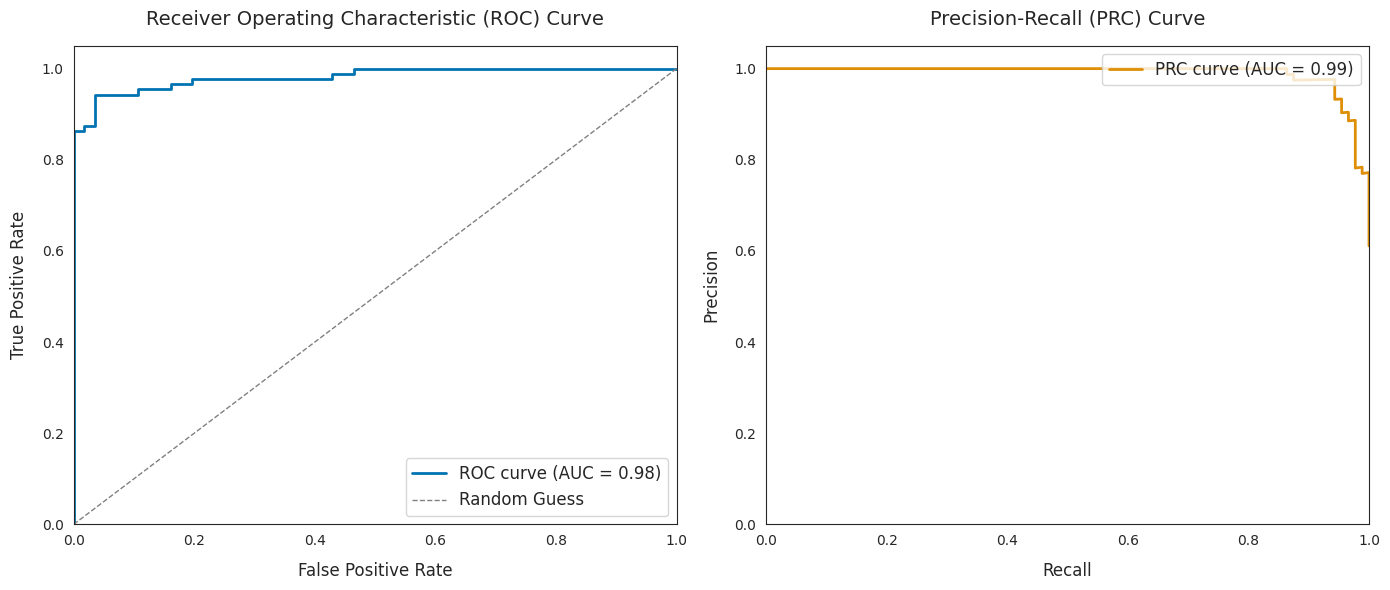

ROC and PRC curves saved to models//ROC_PRC_padel_RandomForest.png
Best Random Forest model saved to models//best_rf_model_padel.joblib


Running pipeline for model: extra_trees with descriptor: padel
Dataset sizes for padel with extra_trees:
Training set: X_train: (321, 664), y_train: (321,)
Validation set: X_val: (71, 664), y_val: (71,)
Test set: X_test: (144, 664), y_test: (144,)
After SMOTE, training set sizes for padel with extra_trees:
X_train_res: (396, 664), y_train_res: (396,)
100%|██████████| 1000/1000 [09:13<00:00,  1.81trial/s, best loss: -0.9204545454545454]
Best hyperparameters found for Extra Trees (padel):  {'bootstrap': 1, 'max_depth': 40.0, 'max_features': 2, 'min_samples_leaf': 15.0, 'min_samples_split': 12.0, 'n_estimators': 100.0}

Extra Trees Model Performance on Test Set (padel):
Precision: 0.9529
Recall:    0.9205
F1-Score:  0.9364
Balanced Accuracy: 0.9245
AUC-ROC:   0.9742

Classification Report:
              precision    recall  f1-score   support

         

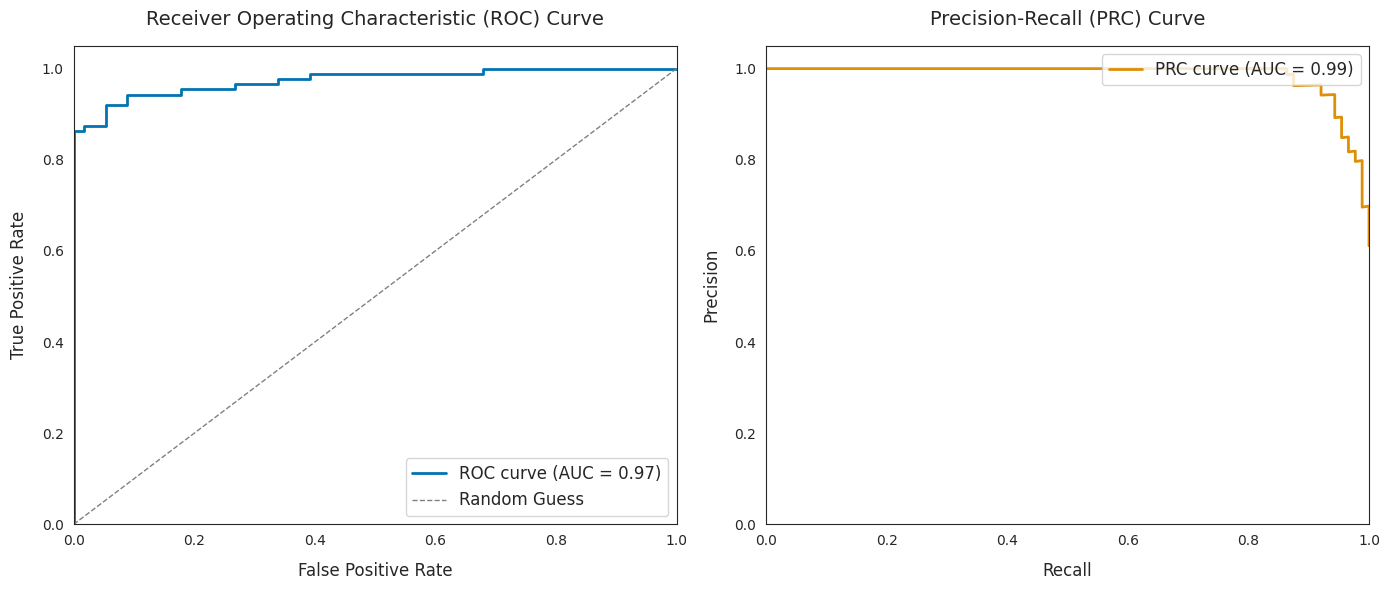

ROC and PRC curves saved to models//ROC_PRC_padel_ExtraTrees.png
Best Extra Trees model saved to models//best_et_model_padel.joblib


Processing descriptor method: maccs

Running pipeline for model: random_forest with descriptor: maccs
Dataset sizes for maccs with random_forest:
Training set: X_train: (321, 167), y_train: (321,)
Validation set: X_val: (71, 167), y_val: (71,)
Test set: X_test: (144, 167), y_test: (144,)
After SMOTE, training set sizes for maccs with random_forest:
X_train_res: (396, 167), y_train_res: (396,)
100%|██████████| 1000/1000 [14:42<00:00,  1.13trial/s, best loss: -0.9090909090909092]
Best hyperparameters found for Random Forest (maccs):  {'bootstrap': 0, 'max_depth': 27.0, 'max_features': 2, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 700.0}

Random Forest Model Performance on Test Set (maccs):
Precision: 0.9412
Recall:    0.9091
F1-Score:  0.9249
Balanced Accuracy: 0.9099
AUC-ROC:   0.9606

Classification Report:
              precision

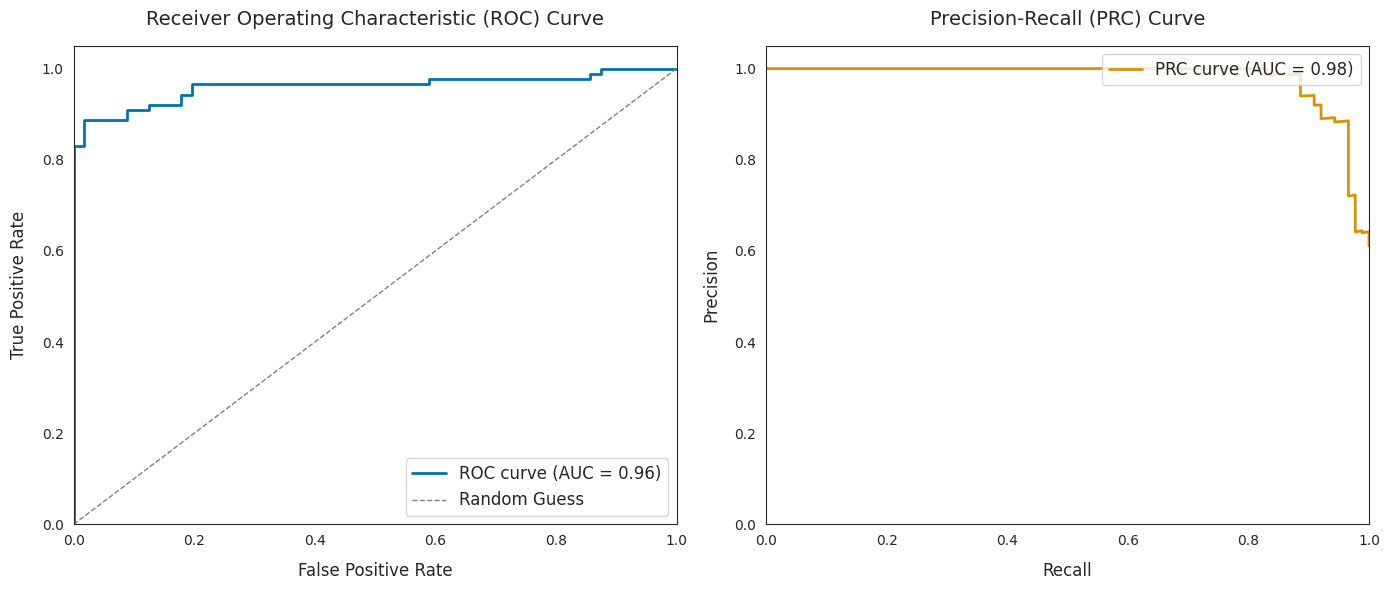

ROC and PRC curves saved to models//ROC_PRC_maccs_RandomForest.png
Best Random Forest model saved to models//best_rf_model_maccs.joblib


Running pipeline for model: extra_trees with descriptor: maccs
Dataset sizes for maccs with extra_trees:
Training set: X_train: (321, 167), y_train: (321,)
Validation set: X_val: (71, 167), y_val: (71,)
Test set: X_test: (144, 167), y_test: (144,)
After SMOTE, training set sizes for maccs with extra_trees:
X_train_res: (396, 167), y_train_res: (396,)
100%|██████████| 1000/1000 [15:57<00:00,  1.04trial/s, best loss: -0.9090909090909092]
Best hyperparameters found for Extra Trees (maccs):  {'bootstrap': 0, 'max_depth': 22.0, 'max_features': 2, 'min_samples_leaf': 2.0, 'min_samples_split': 2.0, 'n_estimators': 200.0}

Extra Trees Model Performance on Test Set (maccs):
Precision: 0.9405
Recall:    0.8977
F1-Score:  0.9186
Balanced Accuracy: 0.9042
AUC-ROC:   0.9604

Classification Report:
              precision    recall  f1-score   support

           

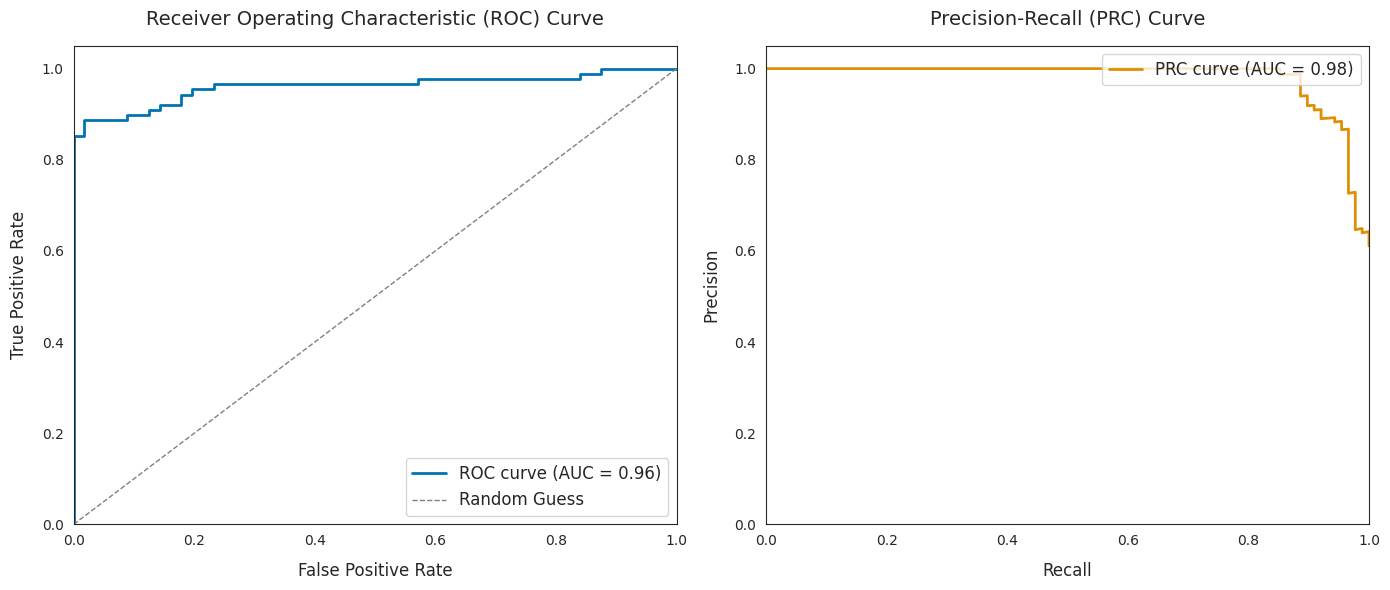

ROC and PRC curves saved to models//ROC_PRC_maccs_ExtraTrees.png
Best Extra Trees model saved to models//best_et_model_maccs.joblib


Processing descriptor method: fcfp

Running pipeline for model: random_forest with descriptor: fcfp
Dataset sizes for fcfp with random_forest:
Training set: X_train: (321, 1024), y_train: (321,)
Validation set: X_val: (71, 1024), y_val: (71,)
Test set: X_test: (144, 1024), y_test: (144,)
After SMOTE, training set sizes for fcfp with random_forest:
X_train_res: (396, 1024), y_train_res: (396,)
100%|██████████| 1000/1000 [18:06<00:00,  1.09s/trial, best loss: -0.8876262626262625]
Best hyperparameters found for Random Forest (fcfp):  {'bootstrap': 1, 'max_depth': 15.0, 'max_features': 2, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 850.0}

Random Forest Model Performance on Test Set (fcfp):
Precision: 0.9157
Recall:    0.8636
F1-Score:  0.8889
Balanced Accuracy: 0.8693
AUC-ROC:   0.9207

Classification Report:
              precision  

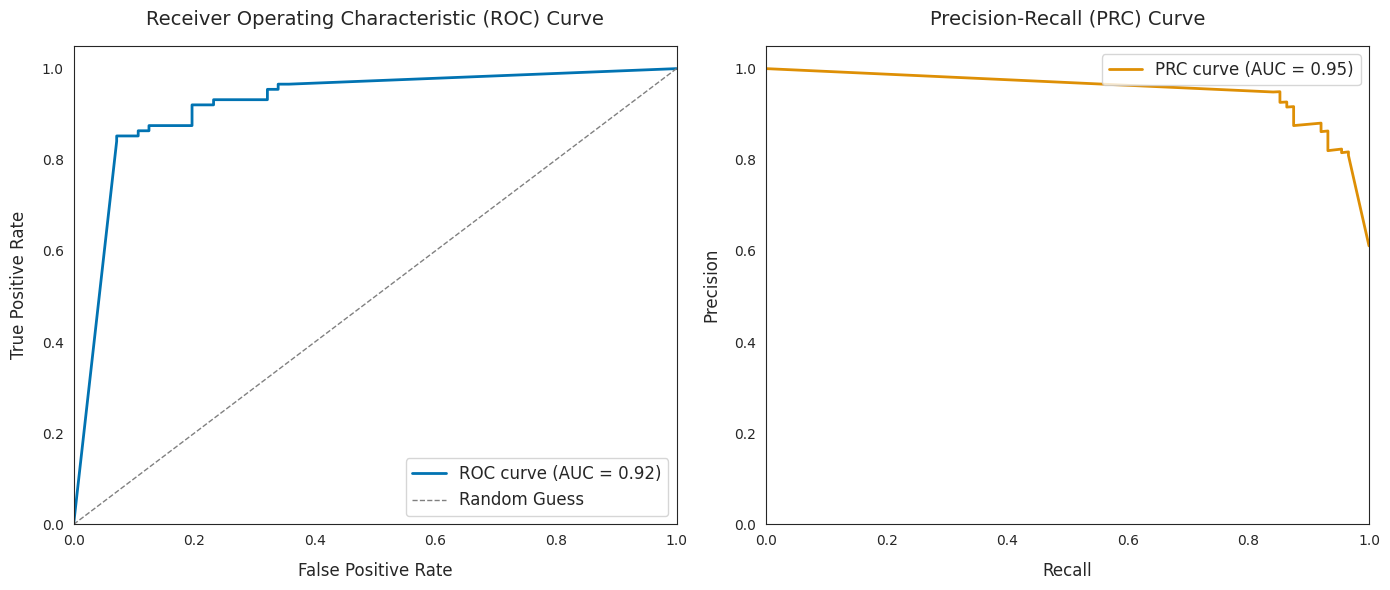

ROC and PRC curves saved to models//ROC_PRC_fcfp_RandomForest.png
Best Random Forest model saved to models//best_rf_model_fcfp.joblib


Running pipeline for model: extra_trees with descriptor: fcfp
Dataset sizes for fcfp with extra_trees:
Training set: X_train: (321, 1024), y_train: (321,)
Validation set: X_val: (71, 1024), y_val: (71,)
Test set: X_test: (144, 1024), y_test: (144,)
After SMOTE, training set sizes for fcfp with extra_trees:
X_train_res: (396, 1024), y_train_res: (396,)
100%|██████████| 1000/1000 [16:16<00:00,  1.02trial/s, best loss: -0.8876262626262625]
Best hyperparameters found for Extra Trees (fcfp):  {'bootstrap': 1, 'max_depth': 20.0, 'max_features': 2, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 150.0}

Extra Trees Model Performance on Test Set (fcfp):
Precision: 0.9157
Recall:    0.8636
F1-Score:  0.8889
Balanced Accuracy: 0.8693
AUC-ROC:   0.9228

Classification Report:
              precision    recall  f1-score   support

           0  

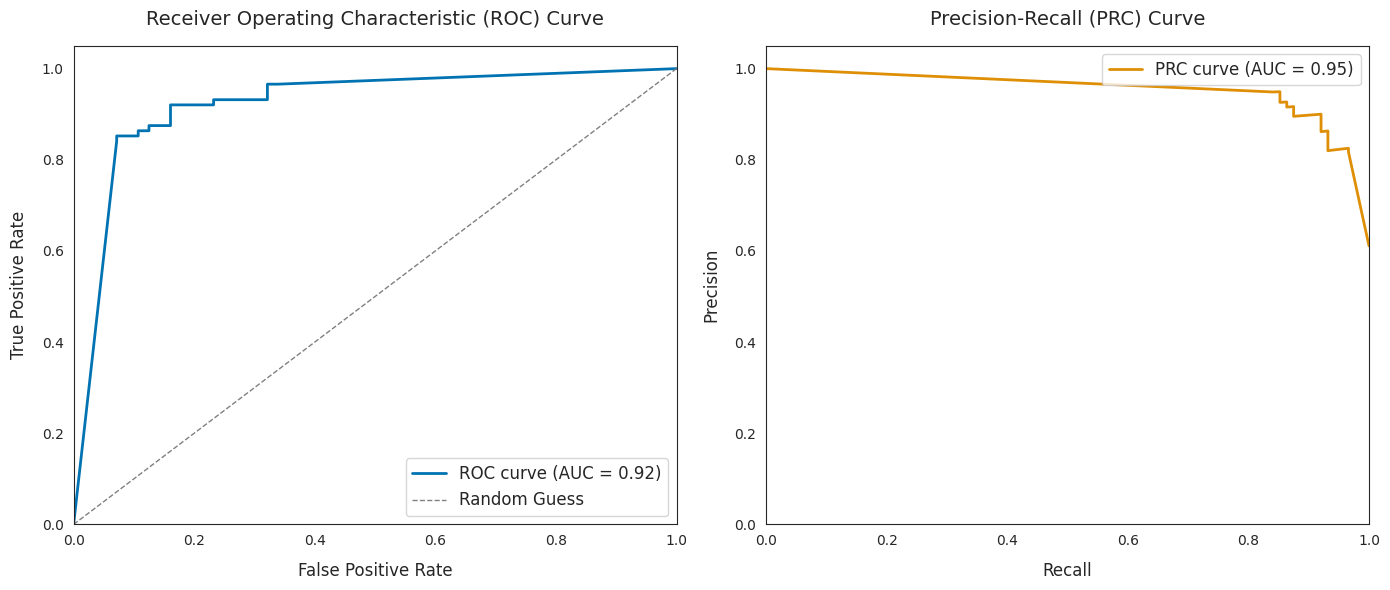

ROC and PRC curves saved to models//ROC_PRC_fcfp_ExtraTrees.png
Best Extra Trees model saved to models//best_et_model_fcfp.joblib


Processing descriptor method: ecfp

Running pipeline for model: random_forest with descriptor: ecfp
Dataset sizes for ecfp with random_forest:
Training set: X_train: (321, 1024), y_train: (321,)
Validation set: X_val: (71, 1024), y_val: (71,)
Test set: X_test: (144, 1024), y_test: (144,)
After SMOTE, training set sizes for ecfp with random_forest:
X_train_res: (396, 1024), y_train_res: (396,)
100%|██████████| 1000/1000 [14:32<00:00,  1.15trial/s, best loss: -0.9019360269360269]
Best hyperparameters found for Random Forest (ecfp):  {'bootstrap': 1, 'max_depth': 39.0, 'max_features': 2, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 150.0}

Random Forest Model Performance on Test Set (ecfp):
Precision: 0.9186
Recall:    0.8977
F1-Score:  0.9080
Balanced Accuracy: 0.8864
AUC-ROC:   0.9214

Classification Report:
              precision   

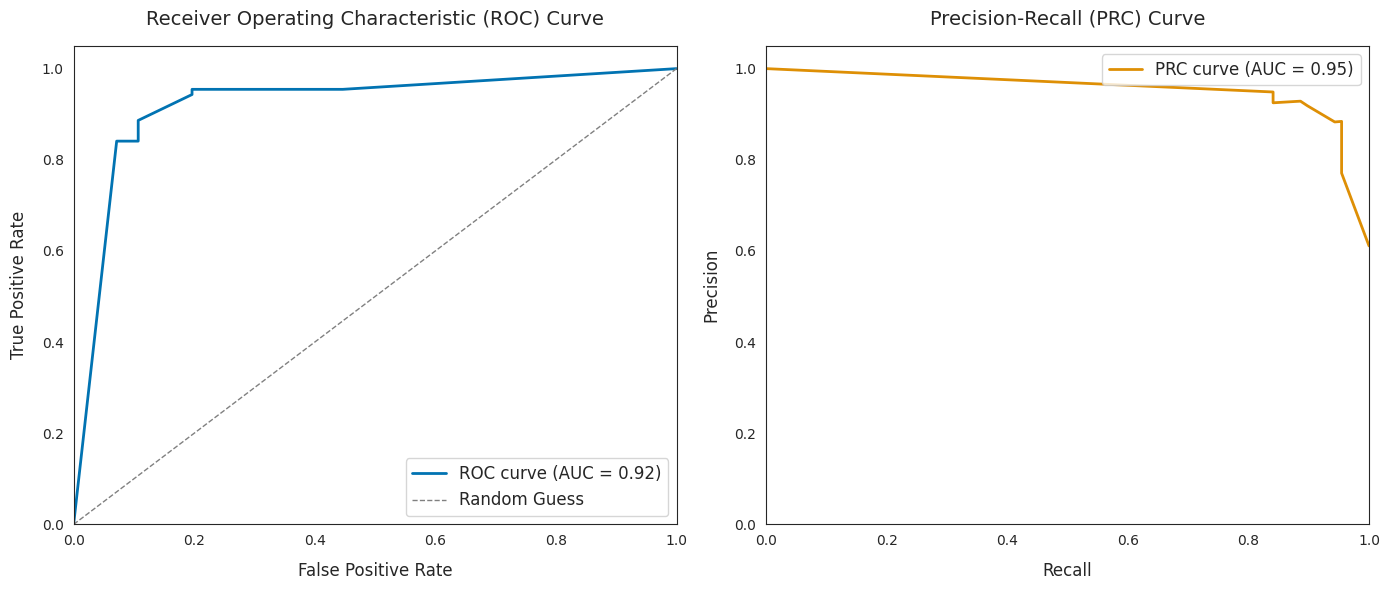

ROC and PRC curves saved to models//ROC_PRC_ecfp_RandomForest.png
Best Random Forest model saved to models//best_rf_model_ecfp.joblib


Running pipeline for model: extra_trees with descriptor: ecfp
Dataset sizes for ecfp with extra_trees:
Training set: X_train: (321, 1024), y_train: (321,)
Validation set: X_val: (71, 1024), y_val: (71,)
Test set: X_test: (144, 1024), y_test: (144,)
After SMOTE, training set sizes for ecfp with extra_trees:
X_train_res: (396, 1024), y_train_res: (396,)
100%|██████████| 1000/1000 [17:40<00:00,  1.06s/trial, best loss: -0.9019360269360269]
Best hyperparameters found for Extra Trees (ecfp):  {'bootstrap': 1, 'max_depth': 39.0, 'max_features': 2, 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 150.0}

Extra Trees Model Performance on Test Set (ecfp):
Precision: 0.9186
Recall:    0.8977
F1-Score:  0.9080
Balanced Accuracy: 0.8864
AUC-ROC:   0.9214

Classification Report:
              precision    recall  f1-score   support

           0 

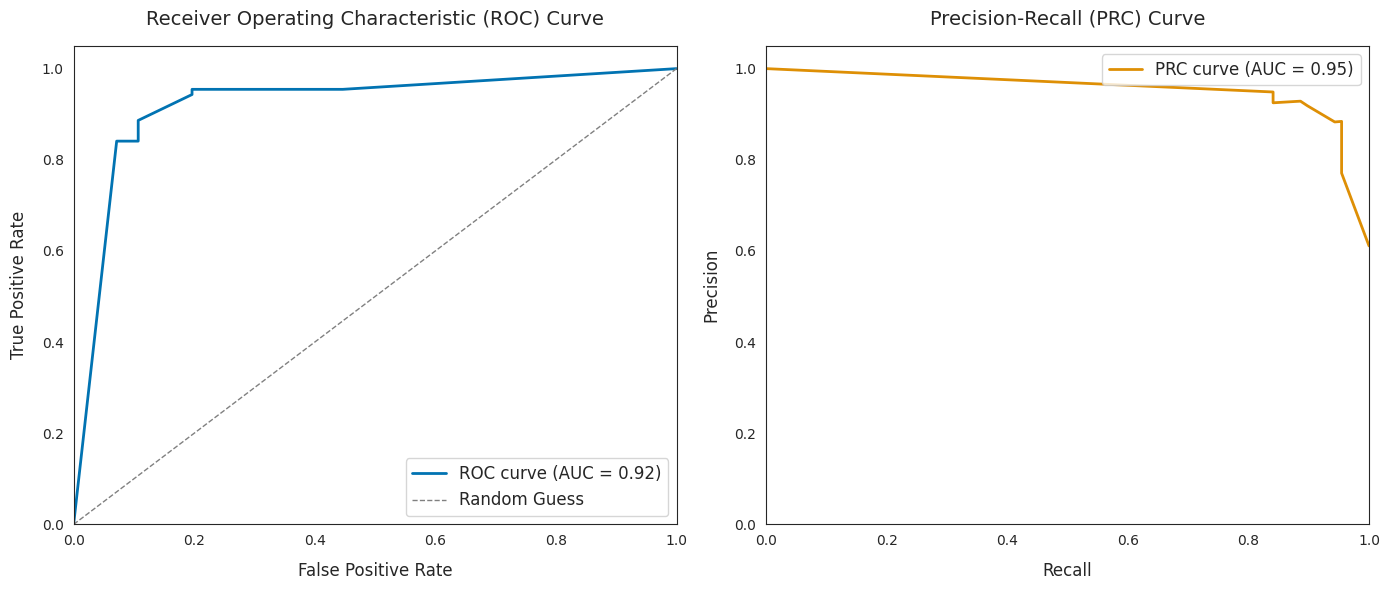

ROC and PRC curves saved to models//ROC_PRC_ecfp_ExtraTrees.png
Best Extra Trees model saved to models//best_et_model_ecfp.joblib


Processing descriptor method: rdkit

Running pipeline for model: random_forest with descriptor: rdkit
Dataset sizes for rdkit with random_forest:
Training set: X_train: (321, 145), y_train: (321,)
Validation set: X_val: (71, 145), y_val: (71,)
Test set: X_test: (144, 145), y_test: (144,)
After SMOTE, training set sizes for rdkit with random_forest:
X_train_res: (396, 145), y_train_res: (396,)
100%|██████████| 1000/1000 [09:56<00:00,  1.68trial/s, best loss: -0.9246632996632996]
Best hyperparameters found for Random Forest (rdkit):  {'bootstrap': 1, 'max_depth': 28.0, 'max_features': 1, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0, 'n_estimators': 100.0}

Random Forest Model Performance on Test Set (rdkit):
Precision: 0.9540
Recall:    0.9432
F1-Score:  0.9486
Balanced Accuracy: 0.9359
AUC-ROC:   0.9825

Classification Report:
              precision  

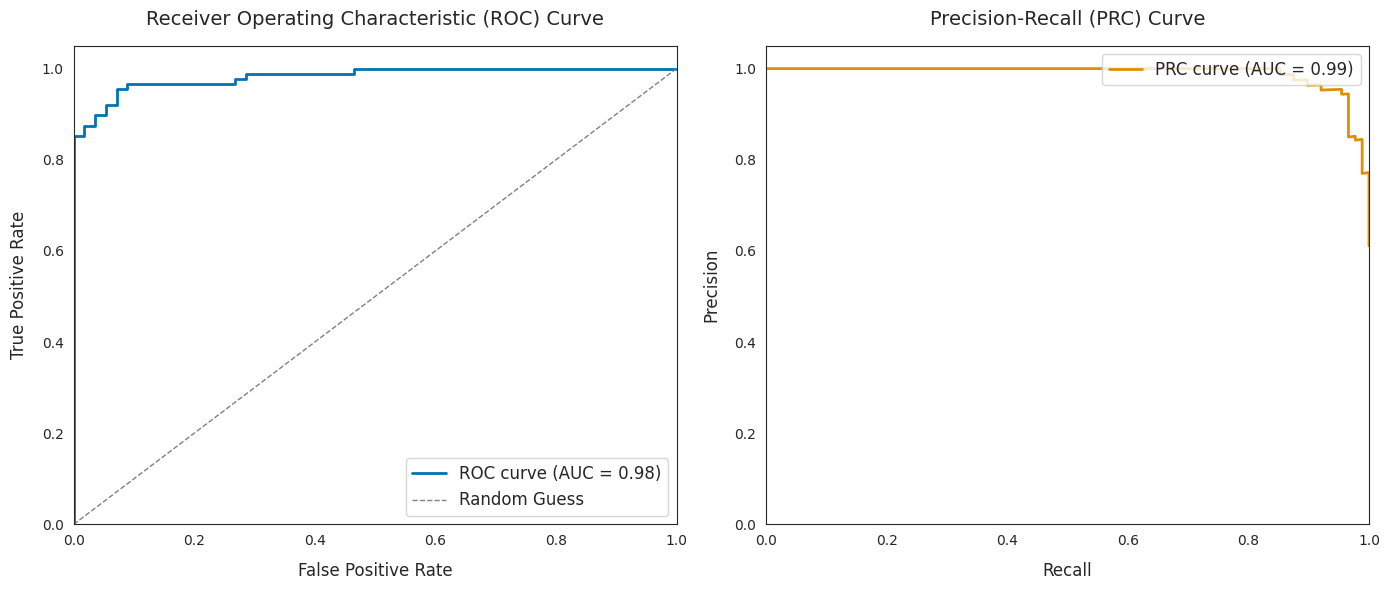

ROC and PRC curves saved to models//ROC_PRC_rdkit_RandomForest.png
Best Random Forest model saved to models//best_rf_model_rdkit.joblib


Running pipeline for model: extra_trees with descriptor: rdkit
Dataset sizes for rdkit with extra_trees:
Training set: X_train: (321, 145), y_train: (321,)
Validation set: X_val: (71, 145), y_val: (71,)
Test set: X_test: (144, 145), y_test: (144,)
After SMOTE, training set sizes for rdkit with extra_trees:
X_train_res: (396, 145), y_train_res: (396,)
100%|██████████| 1000/1000 [10:23<00:00,  1.60trial/s, best loss: -0.9318181818181819]
Best hyperparameters found for Extra Trees (rdkit):  {'bootstrap': 1, 'max_depth': 41.0, 'max_features': 2, 'min_samples_leaf': 3.0, 'min_samples_split': 6.0, 'n_estimators': 150.0}

Extra Trees Model Performance on Test Set (rdkit):
Precision: 0.9540
Recall:    0.9432
F1-Score:  0.9486
Balanced Accuracy: 0.9359
AUC-ROC:   0.9803

Classification Report:
              precision    recall  f1-score   support

           

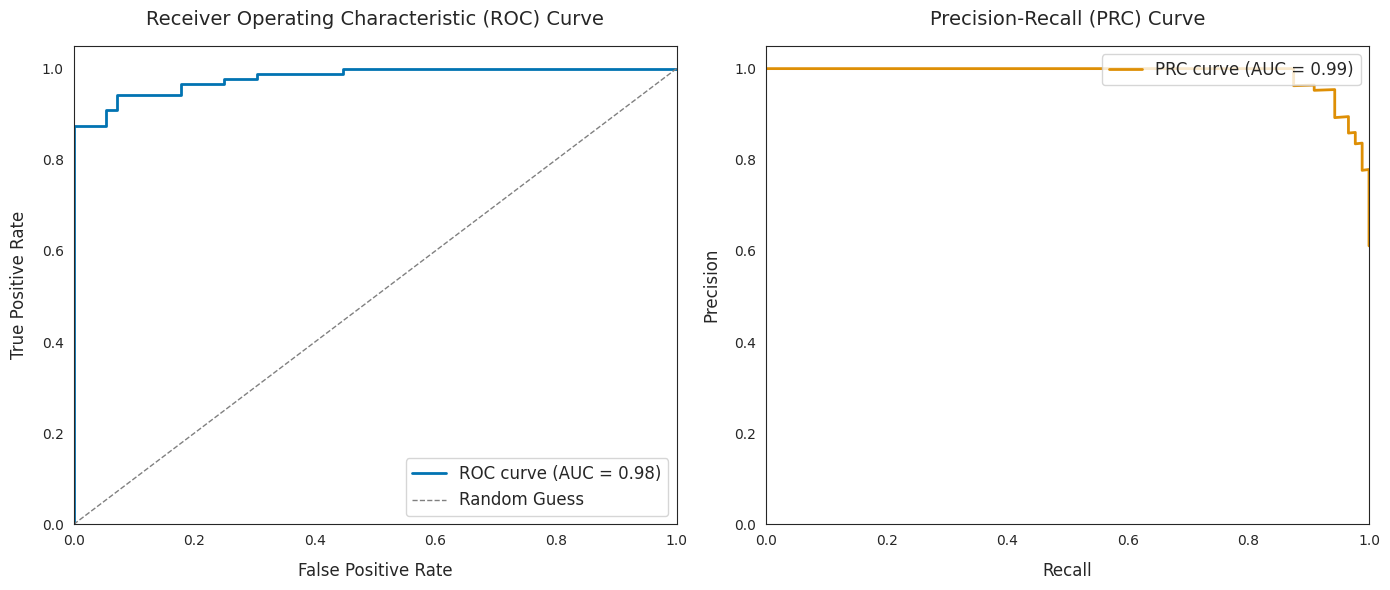

ROC and PRC curves saved to models//ROC_PRC_rdkit_ExtraTrees.png
Best Extra Trees model saved to models//best_et_model_rdkit.joblib


All results saved to models/all_descriptor_model_results.csv

Summary of All Descriptor Methods and Models:
                        Model Type Precision    Recall  F1-Score  \
padel_random_forest  Random Forest  0.943182  0.943182  0.943182   
padel_extra_trees      Extra Trees  0.952941  0.920455  0.936416   
maccs_random_forest  Random Forest  0.941176  0.909091  0.924855   
maccs_extra_trees      Extra Trees  0.940476  0.897727  0.918605   
fcfp_random_forest   Random Forest  0.915663  0.863636  0.888889   
fcfp_extra_trees       Extra Trees  0.915663  0.863636  0.888889   
ecfp_random_forest   Random Forest  0.918605  0.897727  0.908046   
ecfp_extra_trees       Extra Trees  0.918605  0.897727  0.908046   
rdkit_random_forest  Random Forest  0.954023  0.943182  0.948571   
rdkit_extra_trees      Extra Trees  0.954023  0.943182  0.948571   

         

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
results_csv_path = 'models/all_descriptor_trees_model_results.csv'